In [1]:
%%bash
# If you are on Google Colab, this sets up everything needed.
# If not, you will want to pip install the cs7150lib as shown below.
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install git+https://github.com/cs7150/cs7150lib@main

## Zig-zag optimization exercise.

Run the visualization code below without changing it.  Exercise starts below.

In [2]:
from baukit import Widget, PlotWidget, Range, show
class HistoryVisualizer(Widget):
    def __init__(self, data, labels, data_history, vec_history, weight_history):
        super().__init__()
        self.data = data
        self.labels = labels
        self.data_history = data_history
        self.vec_history = vec_history
        self.weight_history = weight_history
        rw = Range(min=0, max=99, value=0)
        pw = PlotWidget(self.plot_example, i=rw.prop('value'))
        self.content = [rw, pw]
    
    def widget_html(self):
        return show.html(self.content)
        
    def plot_example(self, fig, i=0):
        [ax] = fig.axes
        ax.clear()
        ax.scatter(*(self.data[self.labels == 0].t()))
        ax.scatter(*(self.data[self.labels == 1].t()))
        ax.set_ylim(-6, 6)
        ax.set_xlim(-8, 8)
        ax.axvline(0, c='gray', lw=0.5)
        ax.axhline(0, c='gray', lw=0.5)

        vec = self.vec_history[i]
        w = self.weight_history[i]
        d = self.data_history[i]
        ax.scatter(*d, facecolor='none', edgecolor='red')
        ax.quiver(0, 0, *(vec), color='red', angles='xy', scale_units='xy', scale=1, label='gradient')
        ax.quiver(0, 0, *(w), color='blue', angles='xy', scale_units='xy', scale=1, label='weight')
        s = w.norm()
        ax.plot([10*w[1]/s, -10*w[1]/s], [-10*w[0]/s, 10*w[0]/s], lw=0.2, color='blue', linestyle='dashed')
        ax.legend()

# Zig-zag optimization puzzle.

First, let's define some data.  This is a simple two-class classification problem in 2D.  Here is a plot.

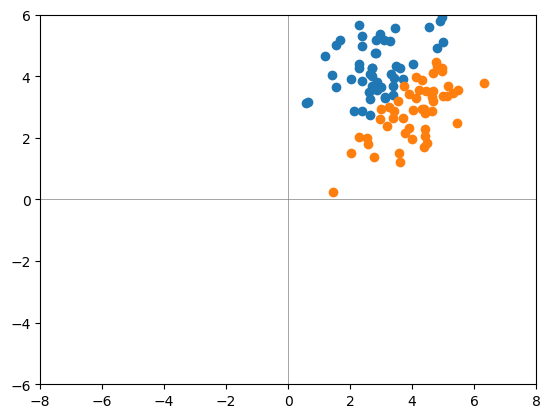

In [9]:
import torch, numpy
from collections import OrderedDict
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh
from matplotlib import pyplot as plt

data = torch.randn(100, 2) + torch.ones(1, 2) * 3.5
labels = (data[:,0] > data[:,1]).long()
plt.scatter(*(data[labels == 0].t()))
plt.scatter(*(data[labels == 1].t()))
plt.ylim(-6, 6)
plt.xlim(-8, 8)
plt.axvline(0, c='gray', lw=0.5)
plt.axhline(0, c='gray', lw=0.5)

## Modeling the data

Now let's model the data.

I will begin with a single-layer (Rosenblatt-style) perceptron, but the same problem shows up with multiple layers.  You can try adding a second or third layer if you like.

In [10]:
# For Exercise 1, just read and run the code.
mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Linear(2, 2, bias=False)),
    # TODO: after experimenting, try adding more layers
    #('ReLU', ReLU()),
    #('layer2', Linear(2, 2, bias=False)),
]))

data_history = []
vec_history = []
weight_history = []

for x, label in zip(data, labels):
    logits = mlp(x[None])
    loss = torch.nn.functional.cross_entropy(logits, label[None])
    loss.backward()
    data_history.append(x.clone())
    vec = mlp.layer1.weight.grad
    vec_history.append(vec[0,:].clone())
    weight_history.append(mlp.layer1.weight[0,:].detach().clone())
    with torch.no_grad():
        for p in mlp.parameters():
            p -= 0.01 * p.grad
            p.grad = None

show(show.TIGHT, [[HistoryVisualizer(data, labels, data_history, vec_history, weight_history)]])

## Training the model

Now we just train the model.

We will compute gradients just one step at a time.

In [13]:

data_history = []
vec_history = []
weight_history = []

for epochs in range(3):
    for x, label in zip(data, labels):
        logits = mlp(x[None])
        loss = torch.nn.functional.cross_entropy(logits, label[None])
        loss.backward()
        data_history.append(x.clone())
        vec = mlp.layer1.weight.grad
        vec_history.append(vec[0,:].clone())
        weight_history.append(mlp.layer1.weight[0,:].detach().clone())
        with torch.no_grad():
            for p in mlp.parameters():
                p -= 0.01 * p.grad
                p.grad = None

show(show.TIGHT, [[HistoryVisualizer(data, labels, data_history, vec_history, weight_history)]])

## What has gone wrong?

Now think about it: what has gone wrong in this optimization?

You can understand the problem if you understand backpropagation well.

We will work it out on the whiteboard.